<a href="https://colab.research.google.com/github/jongbokhi/Time-Series_model/blob/master/prediction_exchange_rate_VARMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MODEL: VARMA

Time-Series datasets : effective_rate(FED), USD/KRW, Brent Oil price, WTi Oil price, Tesla Price

Period: 2010-7-1 ~ 2023-4-27


In [2]:
!pip install fredapi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [60]:
import pandas as pd
import numpy as np
from numpy import cumsum, log, polyfit, sqrt, std, subtract
import seaborn as sns
import datetime
import yfinance as yf
from fredapi import Fred

from statsmodels.tsa.stattools import acf, q_stat, adfuller

import pandas_datareader as pdr

In [124]:
effective_rate_df = pd.read_csv('/content/drive/MyDrive/RIFSPFFNB.csv')

effective_rate_df = effective_rate_df.set_index('DATE')

effective_rate_df.index = pd.to_datetime(effective_rate_df.index)

In [125]:
#change the name of timeindex
effective_rate_df = effective_rate_df.rename_axis('Date')
effective_rate_df.head()

,RIFSPFFNB
Date,
2010-07-01,0.17
2010-07-02,0.18
2010-07-05,NaN
2010-07-06,0.18
2010-07-07,0.18


In [126]:
#load data from Yahoo Finance

tesla = yf.Ticker("TSLA")
brent= yf.Ticker("BZ=F")
wti= yf.Ticker("CL=F")
usd=yf.Ticker("KRW=X")

# get historical market data

start_date = datetime.date(2010, 7, 1)
start_date_str = datetime.datetime.strftime(start_date, "%Y-%m-%d")
end_date= datetime.date(2023, 4, 28)

teslas_hist = tesla.history(start= start_date, end= end_date)
brent_crude_oil =brent.history(start= start_date, end= end_date)
wti_crude_oil =wti.history(start= start_date, end= end_date)
usd_kwon=usd.history(start= start_date, end= end_date)

In [127]:
tesla_open = teslas_hist['Open']
brent_open = brent_crude_oil['Open']
wti_open = wti_crude_oil['Open']
usd_kwon_open = usd_kwon['Open']

In [128]:
#Change Series to Dataframe
usd_kwon_open_df= usd_kwon_open.to_frame(name = 'usd_kwon')
brent_open_df = brent_open.to_frame(name = 'brent_oil')
wti_open_df = wti_open.to_frame(name = 'wti_oil')
tesla_df = tesla_open.to_frame(name = 'tesla_price')

In [129]:
tesla_df

,tesla_price
Date,
2010-07-01 00:00:00-04:00,1.666667
2010-07-02 00:00:00-04:00,1.533333
2010-07-06 00:00:00-04:00,1.333333
2010-07-07 00:00:00-04:00,1.093333
2010-07-08 00:00:00-04:00,1.076000
...,...
2023-04-21 00:00:00-04:00,164.800003
2023-04-24 00:00:00-04:00,164.649994
2023-04-25 00:00:00-04:00,159.820007


In [130]:
usd_kwon_open_df=usd_kwon_open_df.drop('2023-04-28')
print(usd_kwon_open_df)

                              usd_kwon
Date                                  
2010-07-01 00:00:00+01:00  1226.900024
2010-07-02 00:00:00+01:00  1223.199951
2010-07-05 00:00:00+01:00  1200.400024
2010-07-06 00:00:00+01:00  1221.300049
2010-07-07 00:00:00+01:00  1224.000000
...                                ...
2023-04-21 00:00:00+01:00  1323.599976
2023-04-24 00:00:00+01:00  1329.380005
2023-04-25 00:00:00+01:00  1332.800049
2023-04-26 00:00:00+01:00  1341.000000
2023-04-27 00:00:00+01:00  1337.829956

[3340 rows x 1 columns]


In [131]:
# unifiy timezone of timeindex for merging dataframes

tesla_df.index = tesla_df.index.tz_localize(None)
brent_open_df.index = brent_open_df.index.tz_localize(None)
wti_open_df.index = wti_open_df.index.tz_localize(None)
usd_kwon_open_df.index = usd_kwon_open_df.index.tz_localize(None)

In [132]:
# Merge dataframes
merged_df = pd.merge(effective_rate_df, usd_kwon_open_df, on='Date', how='left')

merged_df = pd.merge(merged_df, brent_open_df, on='Date', how='left')

merged_df = pd.merge(merged_df, wti_open_df, on='Date', how='left')

merged_df = pd.merge(merged_df, tesla_df, on='Date', how='left')

In [191]:
merged_df.tail(5)

,RIFSPFFNB,usd_kwon,brent_oil,wti_oil,tesla_price
Date,,,,,
2023-04-21,4.83,1323.599976,80.830002,77.129997,164.800003
2023-04-24,4.83,1329.380005,81.599998,77.970001,164.649994
2023-04-25,4.83,1332.800049,82.580002,78.739998,159.820007
2023-04-26,4.83,1341.000000,81.000000,77.080002,160.289993
2023-04-27,4.83,1337.829956,77.870003,74.379997,152.639999


In [134]:
## Fundamental Functions

In [135]:
# Evaluation matrix
from sklearn import metrics

def timeseries_evaluation_metrics_func(y_true, y_pred):
    
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [136]:
# Dickey_Fuller_Test(Unit-Root test) : Data Stationarity test 

def Augmented_Dickey_Fuller_Test_func(series , column_name):
    print (f'Results of Dickey-Fuller Test for column: {column_name}')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dftest[1] <= 0.05:
        print("Conclusion:====>")
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Conclusion:====>")
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")

In [137]:
#Hurst Exponent

def hurst(ts):
    lags = range(2, 100)
    tau = [sqrt(std(subtract(ts[lag:], ts[:-lag]))) for lag in lags]
    poly = np.polyfit(log(lags), log(tau), 1)
    return poly[0]*2.0

In [138]:
# correlogram function

def plot_correlogram(x, lags=None, title=None):    
    lags = min(10, int(len(x)/5)) if lags is None else lags
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
    x.plot(ax=axes[0][0])
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f} \nHurst: {round(hurst(x.values),2)}'
    axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
    probplot(x, plot=axes[0][1])
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
    axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
    axes[1][0].set_xlabel('Lag')
    axes[1][1].set_xlabel('Lag')
    fig.suptitle(title, fontsize=20)
    fig.tight_layout()
    fig.subplots_adjust(top=.9)

In [139]:
# Load data

In [140]:
df = merged_df.rename(columns={'RIFSPFFNB': 'effective_rate'})
df.head(5)

,effective_rate,usd_kwon,brent_oil,wti_oil,tesla_price
Date,,,,,
2010-07-01,0.17,1226.900024,74.120003,75.370003,1.666667
2010-07-02,0.18,1223.199951,72.489998,72.669998,1.533333
2010-07-05,NaN,1200.400024,NaN,NaN,NaN
2010-07-06,0.18,1221.300049,72.449997,72.059998,1.333333
2010-07-07,0.18,1224.000000,72.260002,72.070000,1.093333


In [141]:
#check missing values
df.isnull().sum()

effective_rate    125
usd_kwon            6
brent_oil         153
wti_oil           117
tesla_price       118
dtype: int64

In [142]:
# Let`s fill missing values with previous value 

# Bfill imputation

df = df.fillna(method='bfill')

In [143]:
df.isnull().sum()

effective_rate    0
usd_kwon          0
brent_oil         0
wti_oil           0
tesla_price       0
dtype: int64

In [144]:
# Create lag features
lags = [1, 7, 30]
lag_features = pd.DataFrame()
for lag in lags:
    lag_features[f'effective_rate_lag{lag}'] = df['effective_rate'].shift(lag)
    lag_features[f'usd_kwon_lag{lag}'] = df['usd_kwon'].shift(lag)
    lag_features[f'brent_oil_lag{lag}'] = df['brent_oil'].shift(lag)
    lag_features[f'wti_oil_lag{lag}'] = df['wti_oil'].shift(lag)
    lag_features[f'tesla_price_lag{lag}'] = df['tesla_price'].shift(lag)

# Create rolling window features
windows = [7, 30, 90]
window_features = pd.DataFrame()
for window in windows:
    window_features[f'effective_rate_mean_{window}d'] = df['effective_rate'].rolling(window).mean()
    window_features[f'usd_kwon_mean_{window}d'] = df['usd_kwon'].rolling(window).mean()
    window_features[f'brent_oil_mean_{window}d'] = df['brent_oil'].rolling(window).mean()
    window_features[f'wti_oil_mean_{window}d'] = df['wti_oil'].rolling(window).mean()
    window_features[f'tesla_price_mean_{window}d'] = df['tesla_price'].rolling(window).mean()
    
    window_features[f'effective_rate_std_{window}d'] = df['effective_rate'].rolling(window).std()
    window_features[f'usd_kwon_std_{window}d'] = df['usd_kwon'].rolling(window).std()
    window_features[f'brent_oil_std_{window}d'] = df['brent_oil'].rolling(window).std()
    window_features[f'wti_oil_std_{window}d'] = df['wti_oil'].rolling(window).std()
    window_features[f'tesla_price_std_{window}d'] = df['tesla_price'].rolling(window).std()

# Merge lag features and rolling window features with the original dataframe
df = pd.concat([df, lag_features, window_features], axis=1)

# Include exogenous variables
exogenous_vars = pd.concat([lag_features, window_features], axis=1)
df = pd.concat([df, exogenous_vars], axis=1)

In [145]:
exogenous_features= ['effective_rate_lag1', 'usd_kwon_lag1', 'brent_oil_lag1',
       'wti_oil_lag1', 'tesla_price_lag1', 'effective_rate_lag7',
       'usd_kwon_lag7', 'brent_oil_lag7', 'wti_oil_lag7', 'tesla_price_lag7',
       'effective_rate_lag30', 'usd_kwon_lag30', 'brent_oil_lag30',
       'wti_oil_lag30', 'tesla_price_lag30', 'effective_rate_mean_7d',
       'usd_kwon_mean_7d', 'brent_oil_mean_7d', 'wti_oil_mean_7d',
       'tesla_price_mean_7d', 'effective_rate_std_7d', 'usd_kwon_std_7d',
       'brent_oil_std_7d', 'wti_oil_std_7d', 'tesla_price_std_7d',
       'effective_rate_mean_30d', 'usd_kwon_mean_30d', 'brent_oil_mean_30d',
       'wti_oil_mean_30d', 'tesla_price_mean_30d', 'effective_rate_std_30d',
       'usd_kwon_std_30d', 'brent_oil_std_30d', 'wti_oil_std_30d',
       'tesla_price_std_30d', 'effective_rate_mean_90d', 'usd_kwon_mean_90d',
       'brent_oil_mean_90d', 'wti_oil_mean_90d', 'tesla_price_mean_90d',
       'effective_rate_std_90d', 'usd_kwon_std_90d', 'brent_oil_std_90d',
       'wti_oil_std_90d', 'tesla_price_std_90d']

In [146]:
exogenous_features

['effective_rate_lag1',
 'usd_kwon_lag1',
 'brent_oil_lag1',
 'wti_oil_lag1',
 'tesla_price_lag1',
 'effective_rate_lag7',
 'usd_kwon_lag7',
 'brent_oil_lag7',
 'wti_oil_lag7',
 'tesla_price_lag7',
 'effective_rate_lag30',
 'usd_kwon_lag30',
 'brent_oil_lag30',
 'wti_oil_lag30',
 'tesla_price_lag30',
 'effective_rate_mean_7d',
 'usd_kwon_mean_7d',
 'brent_oil_mean_7d',
 'wti_oil_mean_7d',
 'tesla_price_mean_7d',
 'effective_rate_std_7d',
 'usd_kwon_std_7d',
 'brent_oil_std_7d',
 'wti_oil_std_7d',
 'tesla_price_std_7d',
 'effective_rate_mean_30d',
 'usd_kwon_mean_30d',
 'brent_oil_mean_30d',
 'wti_oil_mean_30d',
 'tesla_price_mean_30d',
 'effective_rate_std_30d',
 'usd_kwon_std_30d',
 'brent_oil_std_30d',
 'wti_oil_std_30d',
 'tesla_price_std_30d',
 'effective_rate_mean_90d',
 'usd_kwon_mean_90d',
 'brent_oil_mean_90d',
 'wti_oil_mean_90d',
 'tesla_price_mean_90d',
 'effective_rate_std_90d',
 'usd_kwon_std_90d',
 'brent_oil_std_90d',
 'wti_oil_std_90d',
 'tesla_price_std_90d']

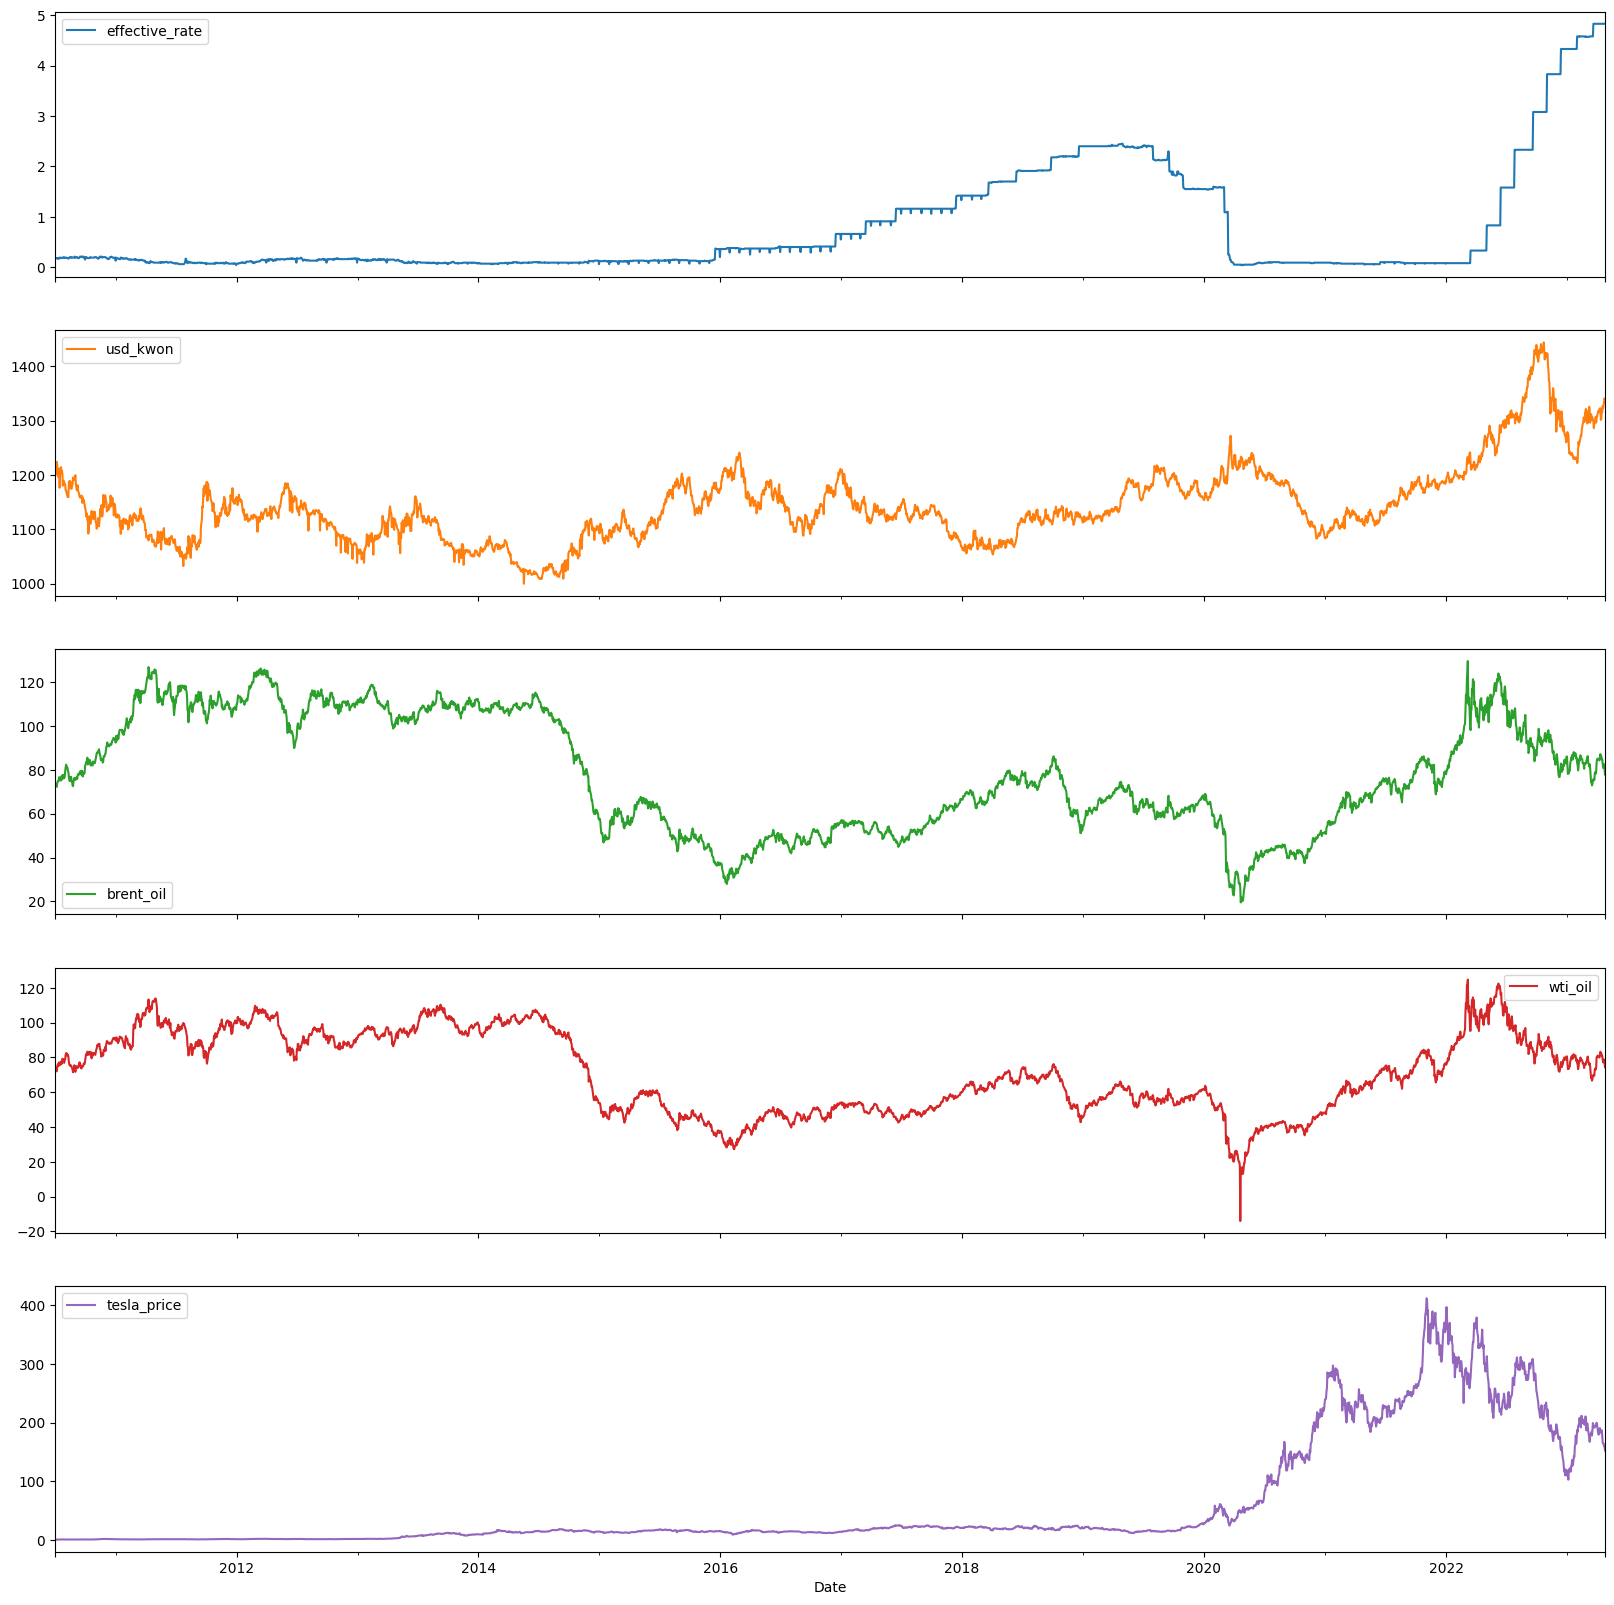

In [147]:
### EDA

#1.Plot Time Series

df[['effective_rate', 'usd_kwon', 'brent_oil', 'wti_oil', 'tesla_price']].plot(subplots=True, figsize=(20,20));

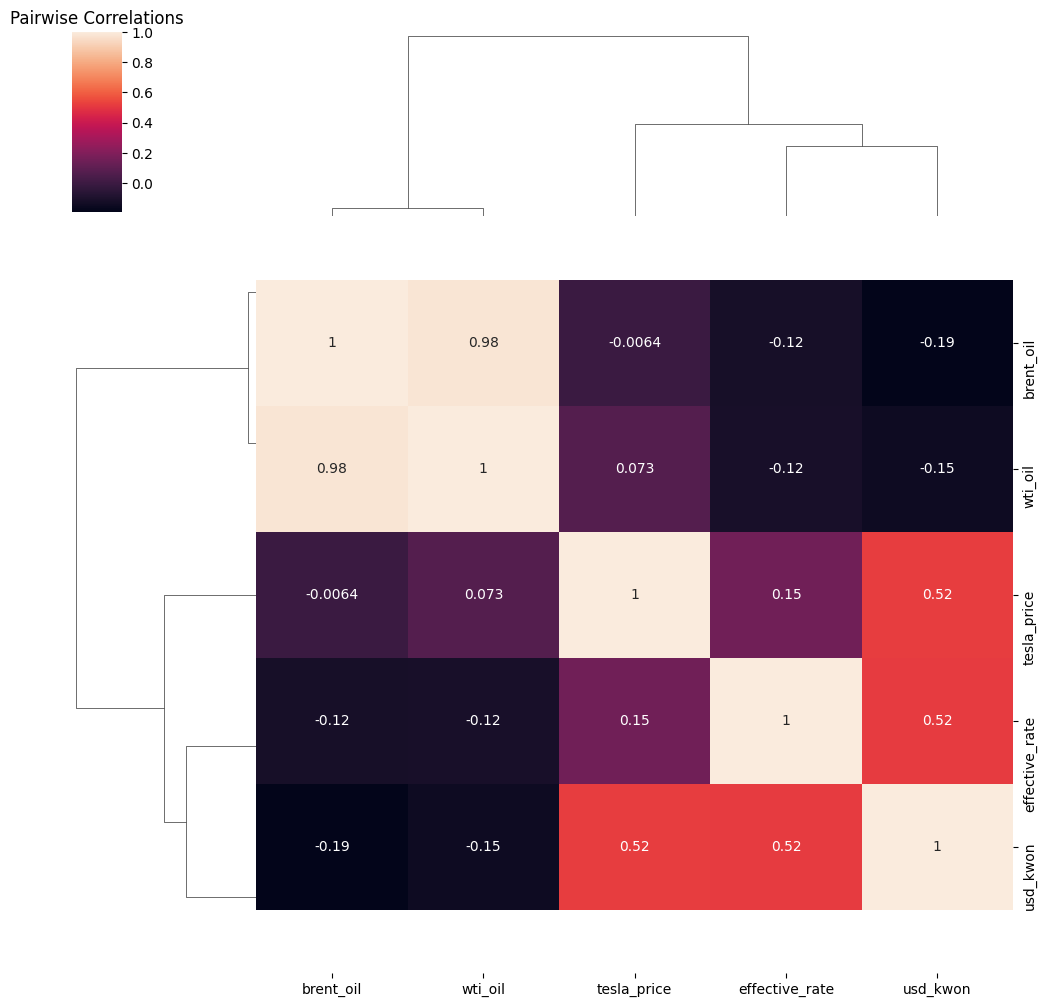

In [148]:
#2.plot Correlation
import matplotlib.pyplot as plt

g = sns.clustermap(df[['effective_rate', 'usd_kwon', 'brent_oil', 'wti_oil', 'tesla_price']].corr(), annot=True)
ax = g.ax_heatmap
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Pairwise Correlations')
plt.show()

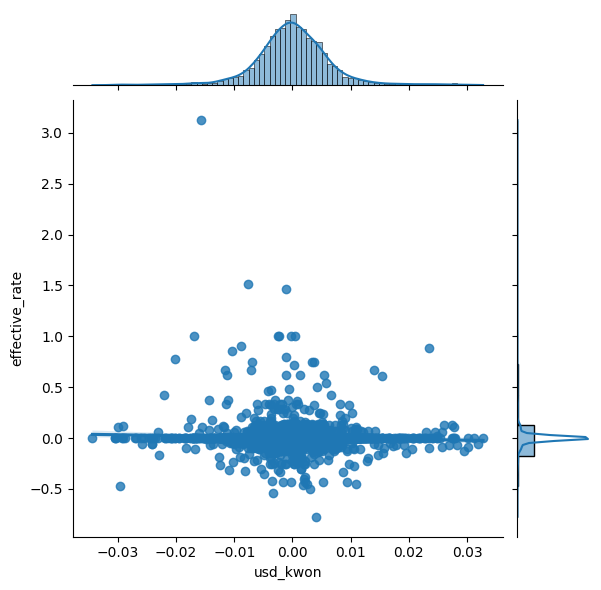

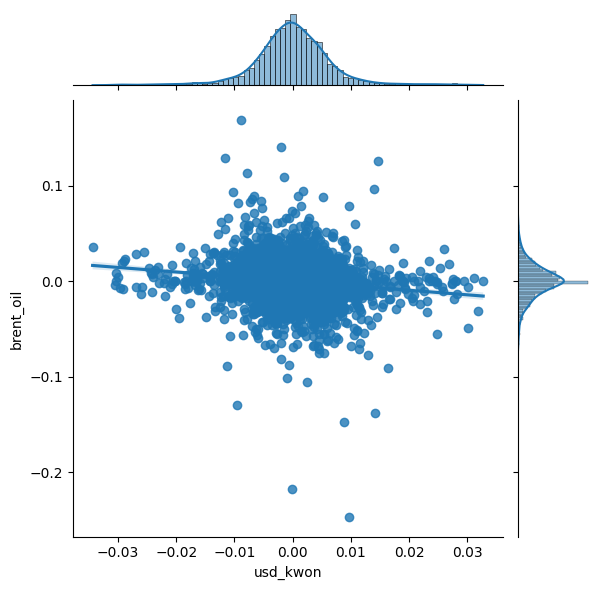

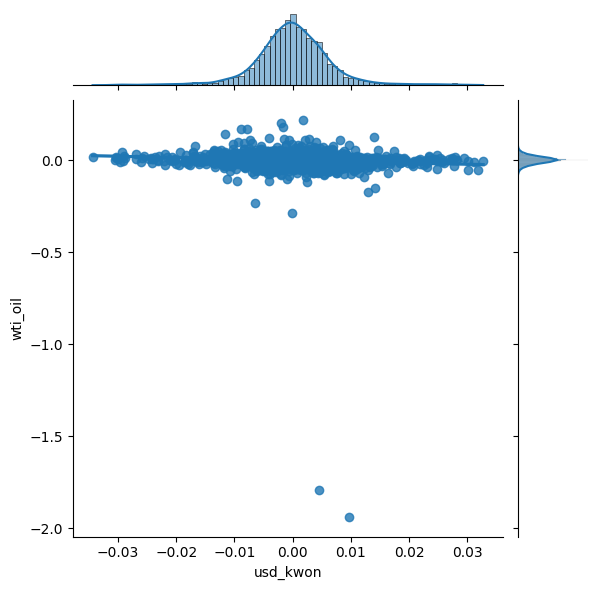

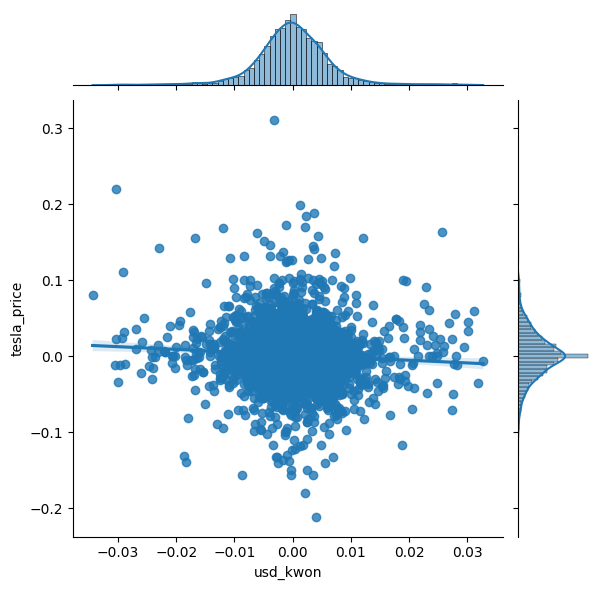

In [149]:
sns.jointplot(x=df.usd_kwon.pct_change().dropna(), y=df.effective_rate.pct_change().dropna(), kind="reg");
sns.jointplot(x=df.usd_kwon.pct_change().dropna(), y=df.brent_oil.pct_change().dropna(), kind="reg");
sns.jointplot(x=df.usd_kwon.pct_change().dropna(), y=df.wti_oil.pct_change().dropna(), kind="reg");
sns.jointplot(x=df.usd_kwon.pct_change().dropna(), y=df.tesla_price.pct_change().dropna(), kind="reg");

In [150]:
# Stationarity Test
from statsmodels.tsa.stattools import adfuller

In [151]:
for name, column in df[['effective_rate', 'usd_kwon', 'brent_oil', 'wti_oil', 'tesla_price']].iteritems():
    Augmented_Dickey_Fuller_Test_func(df[name],name)
    print('\n')

Results of Dickey-Fuller Test for column: effective_rate
Test Statistic                    2.151504
p-value                           0.998840
No Lags Used                      8.000000
Number of Observations Used    3337.000000
Critical Value (1%)              -3.432311
Critical Value (5%)              -2.862407
Critical Value (10%)             -2.567231
dtype: float64
Conclusion:====>
Fail to reject the null hypothesis
Data is non-stationary


Results of Dickey-Fuller Test for column: usd_kwon
Test Statistic                   -1.746273
p-value                           0.407443
No Lags Used                     27.000000
Number of Observations Used    3318.000000
Critical Value (1%)              -3.432322
Critical Value (5%)              -2.862411
Critical Value (10%)             -2.567234
dtype: float64
Conclusion:====>
Fail to reject the null hypothesis
Data is non-stationary


Results of Dickey-Fuller Test for column: brent_oil
Test Statistic                   -1.587155
p-value    

In [152]:
len(df)*0.9

3011.4

In [153]:
# Split dataset into Training and Test
train, test_df = df[0:-550], df[-550:]
print(train.info())  
print(test_df.info()) 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2796 entries, 2010-07-01 to 2021-03-18
Data columns (total 95 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   effective_rate           2796 non-null   float64
 1   usd_kwon                 2796 non-null   float64
 2   brent_oil                2796 non-null   float64
 3   wti_oil                  2796 non-null   float64
 4   tesla_price              2796 non-null   float64
 5   effective_rate_lag1      2795 non-null   float64
 6   usd_kwon_lag1            2795 non-null   float64
 7   brent_oil_lag1           2795 non-null   float64
 8   wti_oil_lag1             2795 non-null   float64
 9   tesla_price_lag1         2795 non-null   float64
 10  effective_rate_lag7      2789 non-null   float64
 11  usd_kwon_lag7            2789 non-null   float64
 12  brent_oil_lag7           2789 non-null   float64
 13  wti_oil_lag7             2789 non-null   float64
 14  tesla_

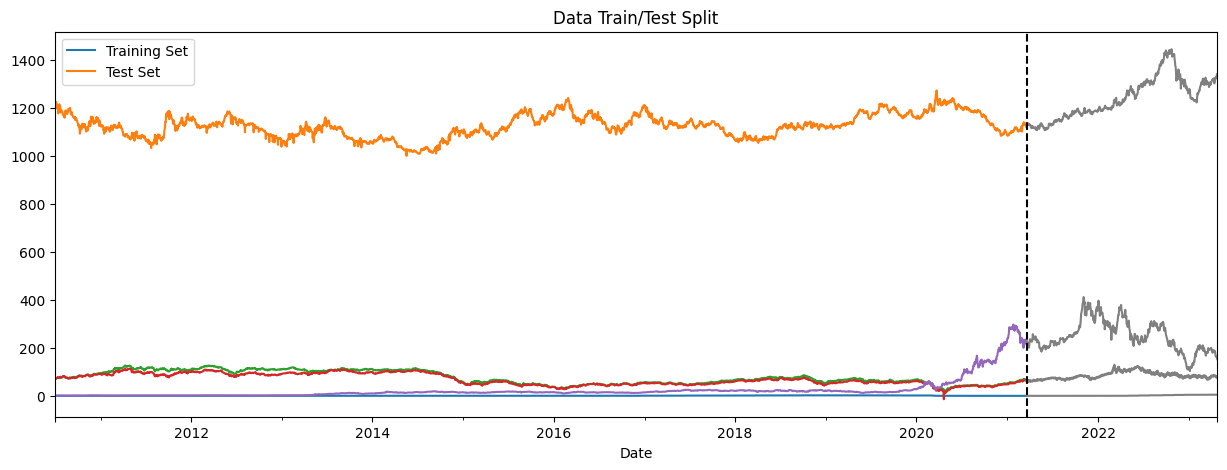

In [154]:
fig, ax = plt.subplots(figsize=(15, 5))
train[['effective_rate', 'usd_kwon', 'brent_oil', 'wti_oil', 'tesla_price']].plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test_df[['effective_rate', 'usd_kwon', 'brent_oil', 'wti_oil', 'tesla_price']].plot(ax=ax, label='Test Set', color='grey')
ax.axvline('2021-03-19', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [155]:
#Transform Non-Stationary data to Stationary data
#log: alleviate variance
#differencing: remove trend

train_diff = np.log(train).diff()
train_diff.dropna(inplace = True)

test_diff = np.log(test_df).diff()
test_diff.dropna(inplace = True)

In [156]:
# Stationarity Test: Transformed data

for name, column in train_diff[['effective_rate', 'usd_kwon', 'brent_oil', 'wti_oil', 'tesla_price']].iteritems():
    Augmented_Dickey_Fuller_Test_func(train_diff[name],name)
    print('\n')

Results of Dickey-Fuller Test for column: effective_rate
Test Statistic                -1.099155e+01
p-value                        7.039161e-20
No Lags Used                   1.100000e+01
Number of Observations Used    1.907000e+03
Critical Value (1%)           -3.433784e+00
Critical Value (5%)           -2.863057e+00
Critical Value (10%)          -2.567577e+00
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


Results of Dickey-Fuller Test for column: usd_kwon
Test Statistic                -1.158672e+01
p-value                        2.855722e-21
No Lags Used                   1.700000e+01
Number of Observations Used    1.901000e+03
Critical Value (1%)           -3.433795e+00
Critical Value (5%)           -2.863062e+00
Critical Value (10%)          -2.567580e+00
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


Results of Dickey-Fuller Test for column: brent_oil
Test Statistic                  -41.478217
p-value              

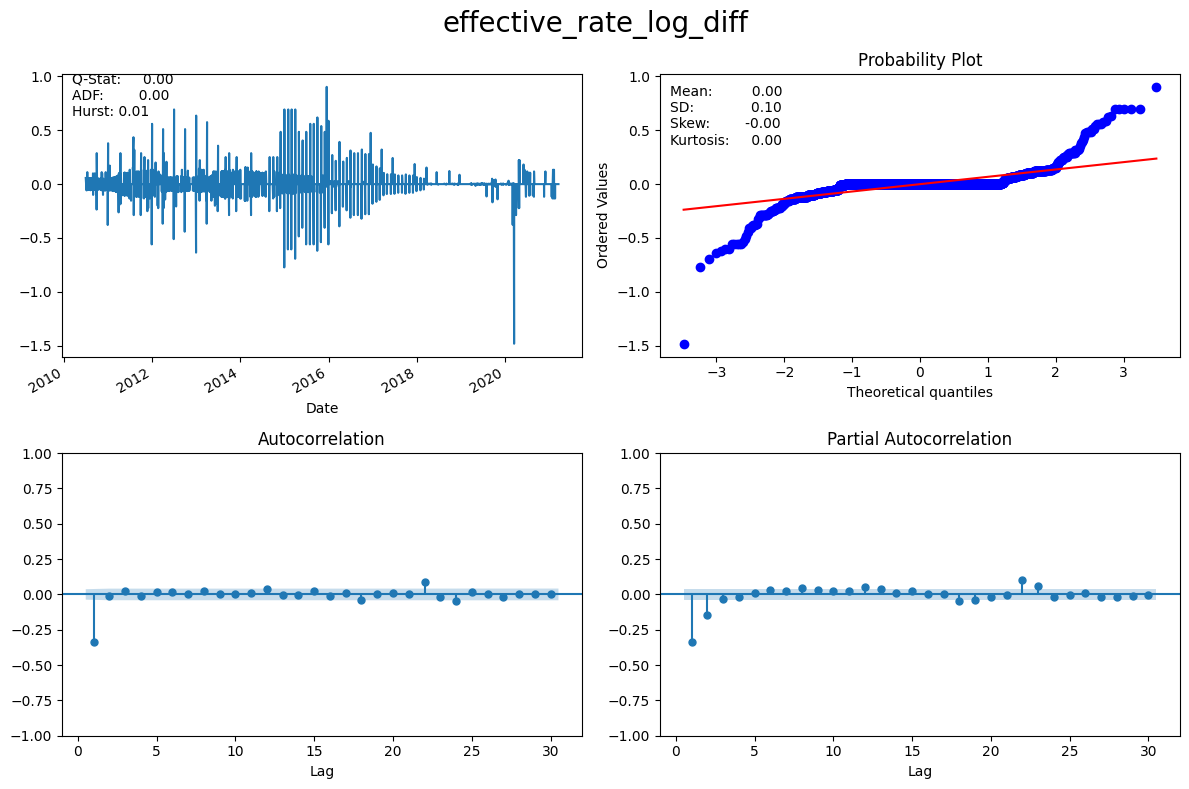

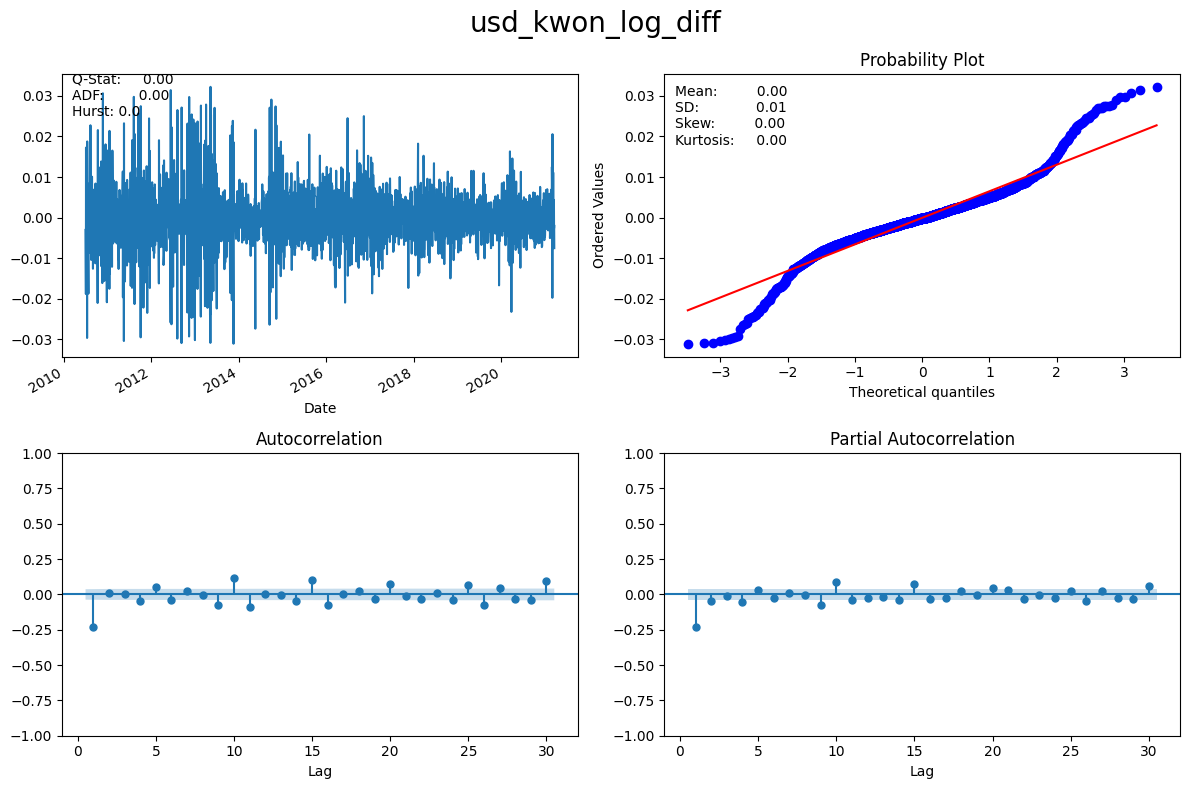

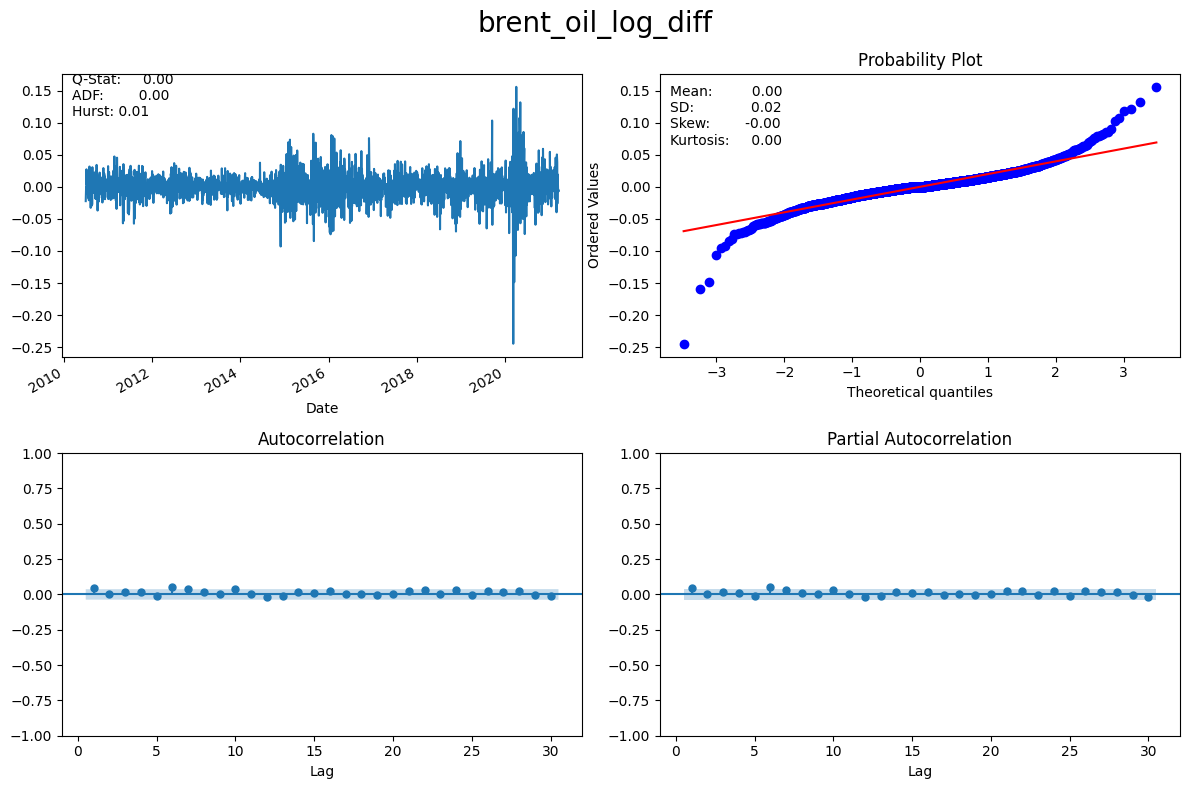

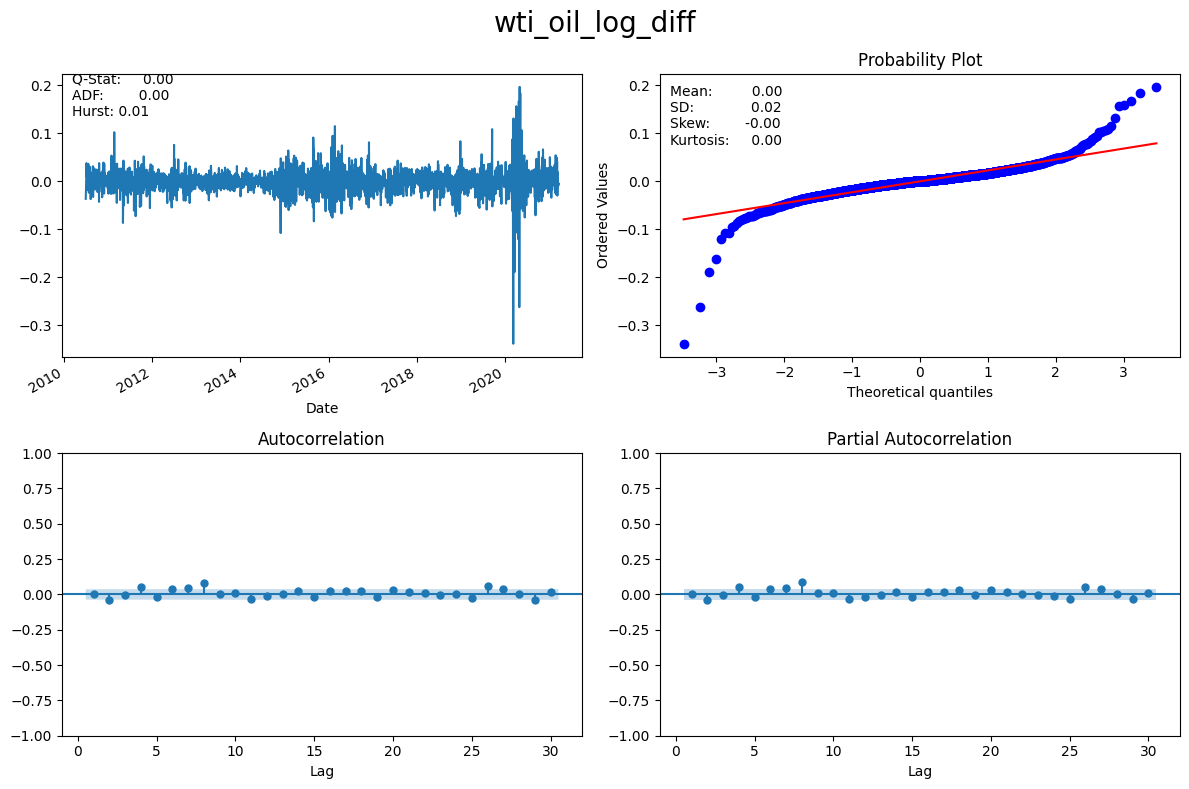

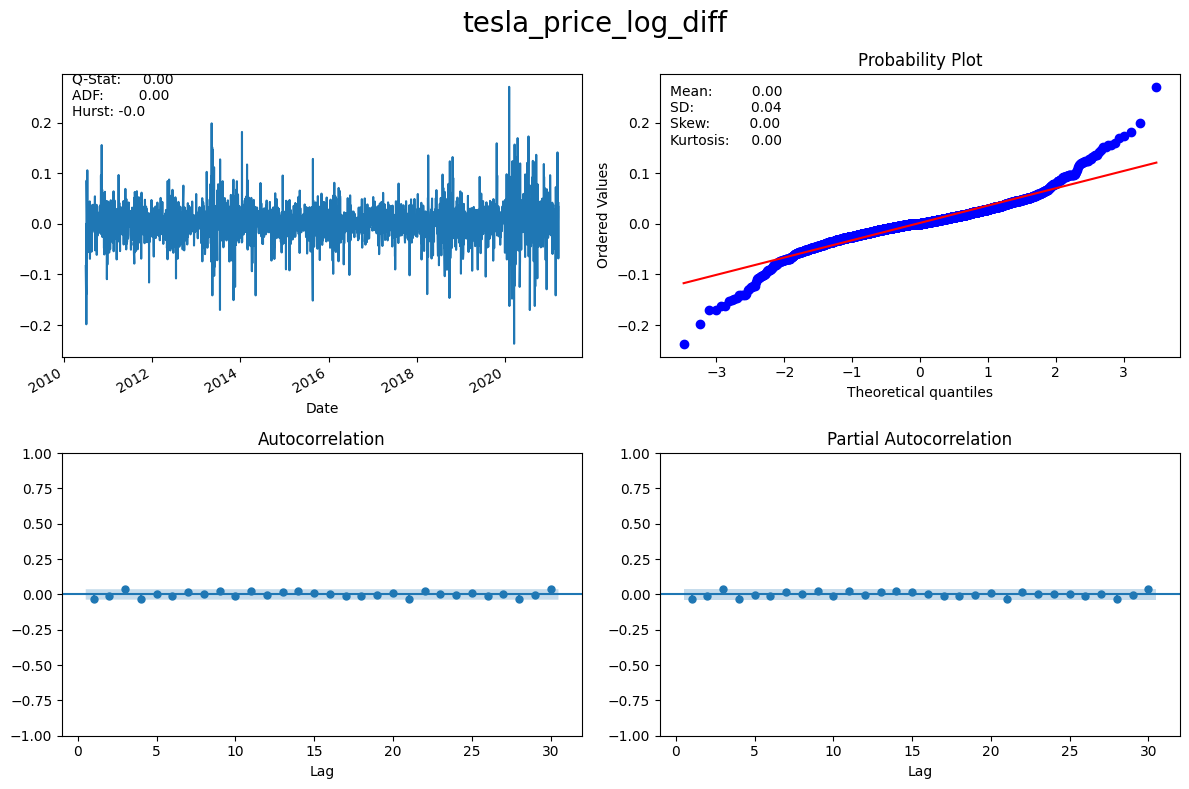

In [94]:
#plot Correlogram
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import probplot, moment
import warnings
warnings.filterwarnings("ignore")

for i in train_diff[['effective_rate', 'usd_kwon', 'brent_oil', 'wti_oil', 'tesla_price']]:
    plot_correlogram(train_diff[i], lags=30, title=f'{i}_log_diff')

In [95]:
### We need to perform Granger’s Causality Test and Cointegration Test after getting Stationarity
### Because Granger’s Causality Test and Cointegration Test are based on Stationariry assumption

In [96]:
# Granger’s Causality Test
#The null hypothesis is that X does not Granger-cause Y 
#(i.e., past values of X do not provide significant information for predicting future values of Y beyond what can be predicted using past values of Y alone)
#The alternative hypothesis is that X does Granger-cause Y
#p-value of the test statistic is below a predetermined significance level (e.g., 0.05)
#then you reject the null hypothesis and conclude that X does Granger-cause Y

In [97]:
from statsmodels.tsa.stattools import grangercausalitytests

maxlag = 12
tes = 'ssr_chi2test'

def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False): 
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

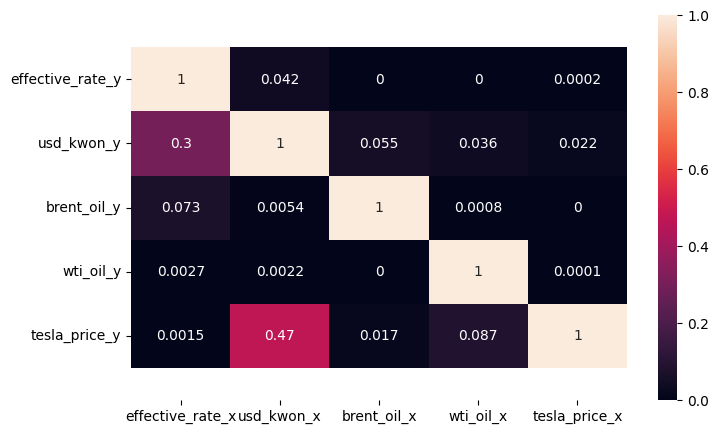

In [98]:
grangers_df = grangers_causation_matrix(train_diff[['effective_rate', 'usd_kwon', 'brent_oil', 'wti_oil', 'tesla_price']], variables = train_diff[['effective_rate', 'usd_kwon', 'brent_oil', 'wti_oil', 'tesla_price']].columns) 

plt.figure(figsize=(8,5))
sns.heatmap(grangers_df, annot=True)
b, t = plt.ylim() 
b += 0.5 
t -= 0.5 
plt.ylim(b, t)
plt.show() 

In [99]:
#Find Significant Pairs in a p-value matrix from Granger’s Causality Test

pairs = grangers_df.unstack()
pairs = pairs.sort_values(kind="quicksort")
mask = pairs < 0.05

print("Significan Pairs")
print(pairs[mask])

Significan Pairs
brent_oil_x       effective_rate_y    0.0000
wti_oil_x         effective_rate_y    0.0000
brent_oil_x       wti_oil_y           0.0000
tesla_price_x     brent_oil_y         0.0000
                  wti_oil_y           0.0001
                  effective_rate_y    0.0002
wti_oil_x         brent_oil_y         0.0008
effective_rate_x  tesla_price_y       0.0015
usd_kwon_x        wti_oil_y           0.0022
effective_rate_x  wti_oil_y           0.0027
usd_kwon_x        brent_oil_y         0.0054
brent_oil_x       tesla_price_y       0.0166
tesla_price_x     usd_kwon_y          0.0223
wti_oil_x         usd_kwon_y          0.0361
usd_kwon_x        effective_rate_y    0.0416
dtype: float64


In [100]:
# Cointegration Test 1
#Cointegration test is a statistical test used to determine whether two or more time series are related by a long-run relationship
#The null hypothesis of a cointegration test is that the time series under consideration are not cointegrated, 
#which means that theny do not have a long-run relationship and tend to diverge from each other in the long run
#the null hypothesis is rejected, it indicates that the time series are cointegrated and have a long-run relationship, 
#and therefore, should be modeled as a single unit rather than separate variables

In [101]:
import statsmodels.api as sm

def find_cointegrated_pairs(dataframe, critial_level = 0.05):
    n = dataframe.shape[1] 
    pvalue_matrix = np.ones((n, n)) 
    keys = dataframe.columns 
    pairs = [] 
    for i in range(n):
        for j in range(i+1, n): 
            series1 = dataframe[keys[i]] 
            series2 = dataframe[keys[j]]
            result = sm.tsa.stattools.coint(series1, series2) 
            pvalue = result[1] 
            pvalue_matrix[i, j] = pvalue
            if pvalue < critial_level: 
                pairs.append((keys[i], keys[j], pvalue)) 
    return pvalue_matrix, pairs

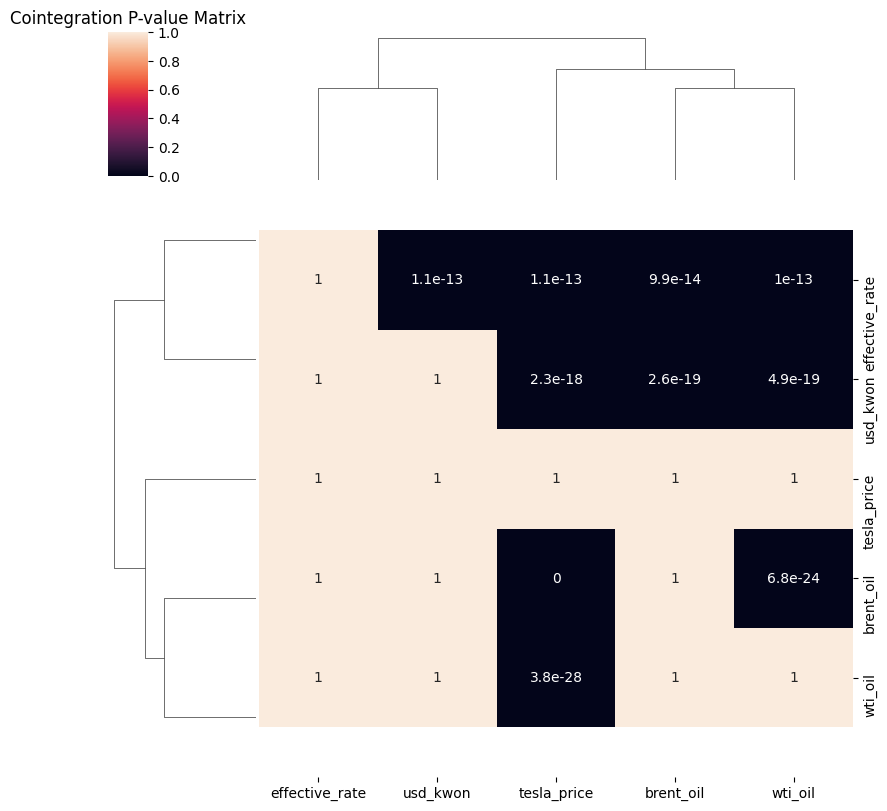

In [102]:
pvalue_matrix, pairs = find_cointegrated_pairs(train_diff[['effective_rate', 'usd_kwon', 'brent_oil', 'wti_oil', 'tesla_price']])
coint_pvalue_matrix_df = pd.DataFrame(pvalue_matrix)

g = sns.clustermap(coint_pvalue_matrix_df, xticklabels=train_diff.columns, yticklabels= train_diff.columns, annot=True, 
                   figsize=(8, 8))
plt.title('Cointegration P-value Matrix')
ax = g.ax_heatmap
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

In [103]:
#Find Significant Pairs in a p-value matrix from Cointegration Test
pairs

[('effective_rate', 'usd_kwon', 1.1106350557167461e-13),
 ('effective_rate', 'brent_oil', 9.947784818089823e-14),
 ('effective_rate', 'wti_oil', 1.0147500018176475e-13),
 ('effective_rate', 'tesla_price', 1.1457763680079055e-13),
 ('usd_kwon', 'brent_oil', 2.6388840523077156e-19),
 ('usd_kwon', 'wti_oil', 4.909135656663084e-19),
 ('usd_kwon', 'tesla_price', 2.310068152515779e-18),
 ('brent_oil', 'wti_oil', 6.835925222281734e-24),
 ('brent_oil', 'tesla_price', 0.0),
 ('wti_oil', 'tesla_price', 3.832497452387343e-28)]

In [104]:
# Cointegration Test2
#The Johansen test is a more advanced test that can be used to test for cointegration among multiple time series simultaneously
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df): 
    res = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = res.lr1
    cvts = res.cvt[:, d[str(1-0.05)]]
    
    def adjust(val, length= 6): 
        return str(val).ljust(length)
   
    print('Column Name   >  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), '> ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

In [105]:
#If the null hypothesis is not rejected, 
#it suggests that the time series are not cointegrated and should be modeled as separate variables.

cointegration_test(train_diff[['effective_rate', 'usd_kwon', 'brent_oil', 'wti_oil', 'tesla_price']])

Column Name   >  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
effective_rate >  2330.83   > 60.0627   =>   True
usd_kwon >  1748.93   > 40.1749   =>   True
brent_oil >  1243.51   > 24.2761   =>   True
wti_oil >  778.62    > 12.3212   =>   True
tesla_price >  352.7     > 4.1296    =>   True


In [106]:
### MODEL: VARMA 
from statsmodels.tsa.api import VAR, VARMAX

In [104]:
from numpy.linalg import LinAlgError

test_results = {}

for p in range(3):
    for q in range(3):
        if p == 0 and q == 0:
            continue
            
        print(f'Testing Order: p = {p}, q = {q}')
        convergence_error = stationarity_error = 0
        
        try:
            model = VARMAX(train_diff[['effective_rate', 'usd_kwon', 'brent_oil', 'wti_oil', 'tesla_price']], 
                           order=(p,q), exogenous=train_diff[exogenous_features], trend='n')
            model_result = model.fit(maxiter=1000, disp=False)
                
        except LinAlgError:
            convergence_error += 1
                
        except ValueError:
            stationarity_error += 1
                
        print('\nAIC:', model_result.aic)
        print('BIC:', model_result.bic)
        print('HQIC:', model_result.hqic)
        print('------------------------')

        test_results[(p, q)] = [model_result.aic,
                                model_result.bic,
                                convergence_error,
                                stationarity_error]


Testing Order: p = 0, q = 1

AIC: -46738.715100933754
BIC: -46514.36027576611
HQIC: -46656.36992055701
------------------------
Testing Order: p = 0, q = 2

AIC: -46757.87782523464
BIC: -46393.3012343372
HQIC: -46624.06690712242
------------------------
Testing Order: p = 1, q = 0

AIC: -46669.41799394236
BIC: -46445.063168774715
HQIC: -46587.07281356562
------------------------
Testing Order: p = 1, q = 1

AIC: -46701.67476941953
BIC: -46337.098178522094
HQIC: -46567.86385130731
------------------------
Testing Order: p = 1, q = 2

AIC: -46720.43420034531
BIC: -46215.6358437181
HQIC: -46535.157544497626
------------------------
Testing Order: p = 2, q = 0

AIC: -46741.993588887715
BIC: -46377.41699799028
HQIC: -46608.182670775495
------------------------
Testing Order: p = 2, q = 1

AIC: -46693.039954336826
BIC: -46188.24159770961
HQIC: -46507.76329848914
------------------------
Testing Order: p = 2, q = 2

AIC: -46671.78249498292
BIC: -46026.762372625926
HQIC: -46435.04010139977
---

In [105]:
test_results = pd.DataFrame(test_results).T
test_results.columns = ['AIC', 'BIC', 'convergence', 'stationarity']
test_results.index.names = ['p', 'q']
test_results.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 8 entries, (0, 1) to (2, 2)
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   AIC           8 non-null      float64
 1   BIC           8 non-null      float64
 2   convergence   8 non-null      float64
 3   stationarity  8 non-null      float64
dtypes: float64(4)
memory usage: 636.0 bytes


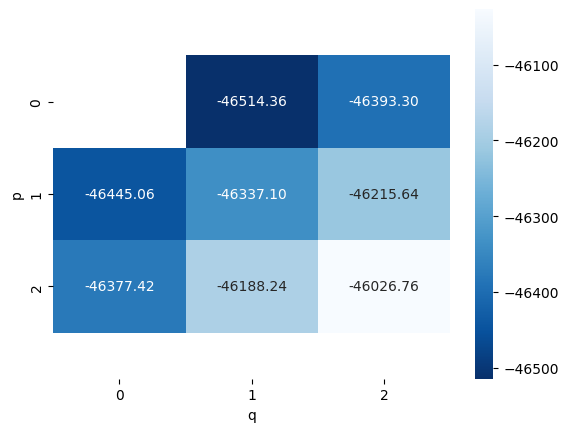

In [106]:
sns.heatmap(test_results.BIC.unstack(), fmt='.2f', annot=True, cmap='Blues_r')
b, t = plt.ylim() 
b += 0.5 
t -= 0.5 
plt.ylim(b, t) 
plt.show()

In [107]:
# Min BIC 
test_results.sort_values('BIC').head()

,,AIC,BIC,convergence,stationarity
p,q,,,,
0,1,-46738.715101,-46514.360276,0.0,0.0
1,0,-46669.417994,-46445.063169,0.0,0.0
0,2,-46757.877825,-46393.301234,0.0,0.0
2,0,-46741.993589,-46377.416998,0.0,0.0
1,1,-46701.674769,-46337.098179,0.0,0.0


In [108]:
min_bic_index = test_results['BIC'].idxmin()
min_bic_pq = f"p={min_bic_index[0]}, q={min_bic_index[1]}"
min_bic_value = test_results.loc[min_bic_index, 'BIC']
print(f"Minimum BIC value: {min_bic_value:.2f} (p={min_bic_index[0]}, q={min_bic_index[1]})")

Minimum BIC value: -46514.36 (p=0, q=1)


In [ ]:
#Estimating with the best VAR Model

In [187]:
#reverse function

def inverse_diff(actual_df, pred_df):
    df_res = pred_df.copy()
    columns = actual_df.columns
    for col in columns:
        df_res[str(col)+'_1st_inv_diff'] = actual_df[col].iloc[-1] + df_res[str(col)].cumsum()
        df_res[str(col)+'_inv_diff'] = np.exp(df_res[str(col)+'_1st_inv_diff']) # reverse log transformation
    return df_res

In [108]:
start_date = pd.to_datetime('2021-03-19')
end_date = pd.to_datetime('2023-04-27')
num_periods = (end_date - start_date).days + 1
num_periods

770

In [114]:
# Using Best parameters(recorded Min BIC) (p,q) : (0,1)

model = VARMAX(train_diff[['effective_rate', 'usd_kwon', 'brent_oil', 'wti_oil', 'tesla_price']], 
               order=(0,1), exogenous=train_diff[exogenous_features]).fit(disp=False)

result = model.forecast(steps = num_periods)

In [222]:
start_date = pd.to_datetime('2021-03-19')
end_date = pd.to_datetime('2023-04-27')
num_periods = (end_date - start_date).days + 1

model = VARMAX(train_diff[['effective_rate', 'usd_kwon', 'brent_oil', 'wti_oil', 'tesla_price']], 
               order=(0,1), exogenous=train_diff[exogenous_features]).fit(disp=False)

result = model.forecast(steps=num_periods, exog=test_df[exogenous_features].values)

# Generate a DatetimeIndex for the forecast period
forecast_index = pd.date_range(start=start_date, end=end_date, freq='D')

# Create a new dataframe for the forecasted values with the appropriate index
forecast_df = pd.DataFrame(index=forecast_index, columns=['effective_rate', 'usd_kwon', 'brent_oil', 'wti_oil', 'tesla_price'])

# Fill in the forecasted values
forecast_df.loc[:, ['effective_rate', 'usd_kwon', 'brent_oil', 'wti_oil', 'tesla_price']] = result.values



In [223]:
#reverse function

def inverse_diff(actual_df, pred_df):
    df_res = pred_df.copy()
    columns = actual_df.columns
    for col in columns:
        df_res[str(col)+'_1st_inv_diff'] = actual_df[col].iloc[-1] + df_res[str(col)].cumsum()
        df_res[str(col)+'_inv_diff'] = np.exp(df_res[str(col)+'_1st_inv_diff']) # reverse log transformation
    return df_res


In [224]:
# Fill NaN values with 0
forecast_df = forecast_df.fillna(0)
# Reverse differencing and log transformation
inv_forecast_df = inverse_diff(test_df[['effective_rate', 'usd_kwon', 'brent_oil', 'wti_oil', 'tesla_price']], forecast_df)

In [225]:
inv_forecast_df

,effective_rate,usd_kwon,brent_oil,wti_oil,tesla_price,effective_rate_1st_inv_diff,effective_rate_inv_diff,usd_kwon_1st_inv_diff,usd_kwon_inv_diff,brent_oil_1st_inv_diff,brent_oil_inv_diff,wti_oil_1st_inv_diff,wti_oil_inv_diff,tesla_price_1st_inv_diff,tesla_price_inv_diff
2021-03-19,-0.001654,-0.001877,-0.001848,-0.004321,0.003215,4.828346,125.004042,1337.828079,inf,77.868155,6.572188e+33,74.375676,1.999612e+32,152.643214,1.959322e+66
2021-03-20,-0.000645,0.000116,-0.000320,-0.000604,0.001620,4.827701,124.923441,1337.828195,inf,77.867835,6.570089e+33,74.375072,1.998405e+32,152.644834,1.962497e+66
2021-03-21,-0.000645,0.000116,-0.000320,-0.000604,0.001620,4.827056,124.842893,1337.828310,inf,77.867516,6.567990e+33,74.374469,1.997199e+32,152.646454,1.965678e+66
2021-03-22,-0.000645,0.000116,-0.000320,-0.000604,0.001620,4.826411,124.762397,1337.828426,inf,77.867196,6.565892e+33,74.373865,1.995994e+32,152.648073,1.968864e+66
2021-03-23,-0.000645,0.000116,-0.000320,-0.000604,0.001620,4.825766,124.681953,1337.828542,inf,77.866877,6.563794e+33,74.373261,1.994789e+32,152.649693,1.972056e+66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-23,-0.000645,0.000116,-0.000320,-0.000604,0.001620,4.334931,76.319671,1337.916512,inf,77.623722,5.146998e+33,73.913888,1.260067e+32,153.882158,6.763508e+66
2023-04-24,-0.000645,0.000116,-0.000320,-0.000604,0.001620,4.334286,76.270462,1337.916628,inf,77.623402,5.145354e+33,73.913284,1.259307e+32,153.883777,6.774470e+66
2023-04-25,-0.000645,0.000116,-0.000320,-0.000604,0.001620,4.333641,76.221284,1337.916743,inf,77.623083,5.143710e+33,73.912681,1.258547e+32,153.885397,6.785451e+66
2023-04-26,-0.000645,0.000116,-0.000320,-0.000604,0.001620,4.332996,76.172139,1337.916859,inf,77.622763,5.142067e+33,73.912077,1.257787e+32,153.887016,6.796449e+66


In [226]:
test_df.index

DatetimeIndex(['2021-03-19', '2021-03-22', '2021-03-23', '2021-03-24',
               '2021-03-25', '2021-03-26', '2021-03-29', '2021-03-30',
               '2021-03-31', '2021-04-01',
               ...
               '2023-04-14', '2023-04-17', '2023-04-18', '2023-04-19',
               '2023-04-20', '2023-04-21', '2023-04-24', '2023-04-25',
               '2023-04-26', '2023-04-27'],
              dtype='datetime64[ns]', name='Date', length=550, freq=None)

In [227]:
inv_forecast_df.index

DatetimeIndex(['2021-03-19', '2021-03-20', '2021-03-21', '2021-03-22',
               '2021-03-23', '2021-03-24', '2021-03-25', '2021-03-26',
               '2021-03-27', '2021-03-28',
               ...
               '2023-04-18', '2023-04-19', '2023-04-20', '2023-04-21',
               '2023-04-22', '2023-04-23', '2023-04-24', '2023-04-25',
               '2023-04-26', '2023-04-27'],
              dtype='datetime64[ns]', length=770, freq='D')

In [228]:
## we have mismatch between len(test_df) and len(inv_forecast_df)
## so we need to adjust len(inv_forecast_df)

In [229]:
inv_forecast_df_truncated = inv_forecast_df.loc[test_df.index]


In [230]:
inv_forecast_df_truncated.index

DatetimeIndex(['2021-03-19', '2021-03-22', '2021-03-23', '2021-03-24',
               '2021-03-25', '2021-03-26', '2021-03-29', '2021-03-30',
               '2021-03-31', '2021-04-01',
               ...
               '2023-04-14', '2023-04-17', '2023-04-18', '2023-04-19',
               '2023-04-20', '2023-04-21', '2023-04-24', '2023-04-25',
               '2023-04-26', '2023-04-27'],
              dtype='datetime64[ns]', name='Date', length=550, freq=None)

In [231]:
#Evaluation model

for i in ['effective_rate', 'usd_kwon', 'brent_oil', 'wti_oil', 'tesla_price']:
    print(f'Evaluation metric for {i}')
    timeseries_evaluation_metrics_func(test_df[str(i)] , inv_forecast_df_truncated[str(i)+'_1st_inv_diff'])



Evaluation metric for effective_rate
Evaluation metric results:-
MSE is : 12.958982882268037
MAE is : 3.120941882559606
RMSE is : 3.5998587308765377
MAPE is : 2947.935327521618
R2 is : -3.0747159341642467

Evaluation metric for usd_kwon
Evaluation metric results:-
MSE is : 17244.02421230204
MAE is : 112.71861768310471
RMSE is : 131.3165039600965
MAPE is : 9.476513601405117
R2 is : -1.346096622457646

Evaluation metric for brent_oil
Evaluation metric results:-
MSE is : 305.67097971200235
MAE is : 13.307689140738555
RMSE is : 17.48344873621913
MAPE is : 14.072446649441153
R2 is : -0.3838146684436423

Evaluation metric for wti_oil
Evaluation metric results:-
MSE is : 293.5131148456508
MAE is : 12.627781738207418
RMSE is : 17.13222445701815
MAPE is : 13.873595969507175
R2 is : -0.36212951299489626

Evaluation metric for tesla_price
Evaluation metric results:-
MSE is : 13176.581300127362
MAE is : 98.42925567314597
RMSE is : 114.78929087736087
MAPE is : 36.27056058179801
R2 is : -2.268289707

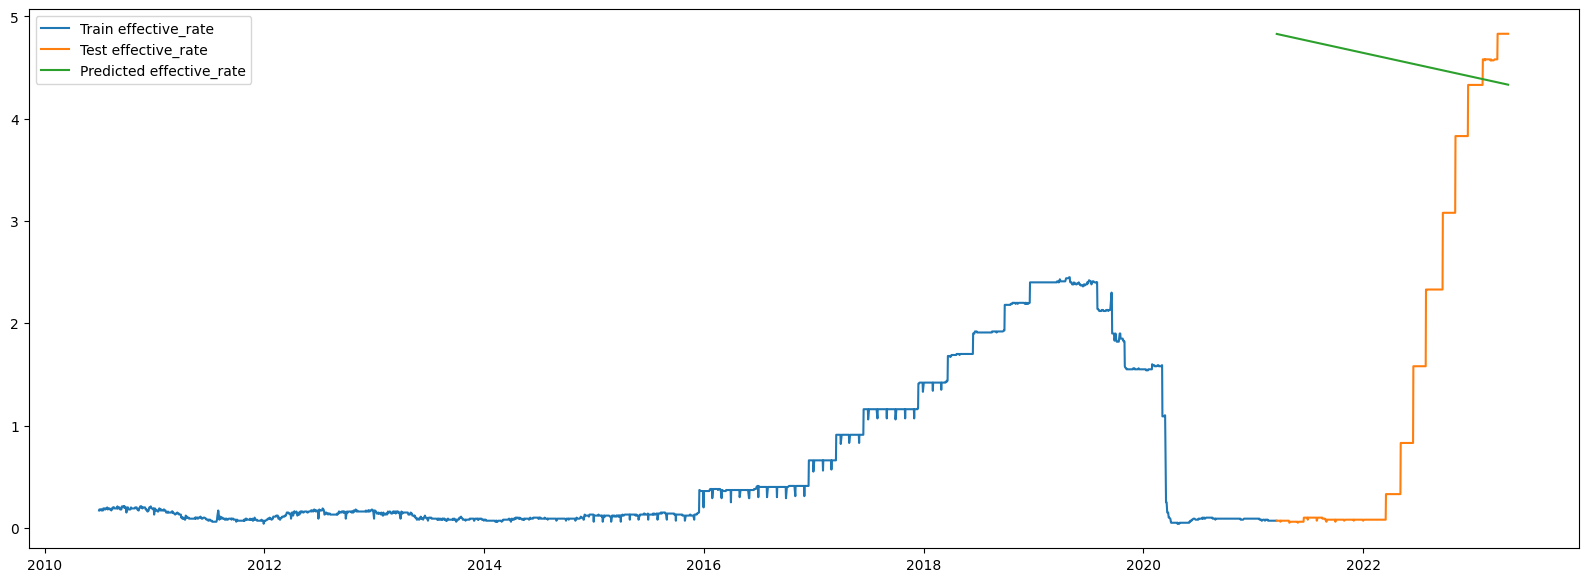

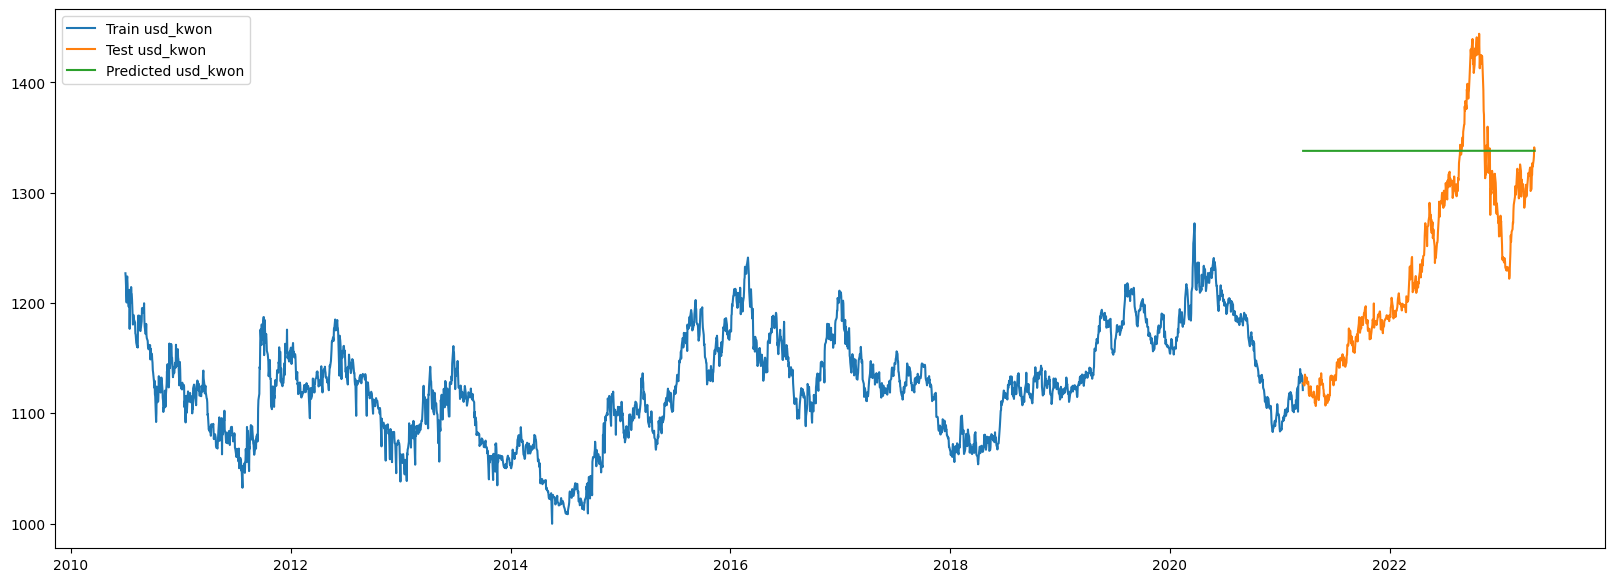

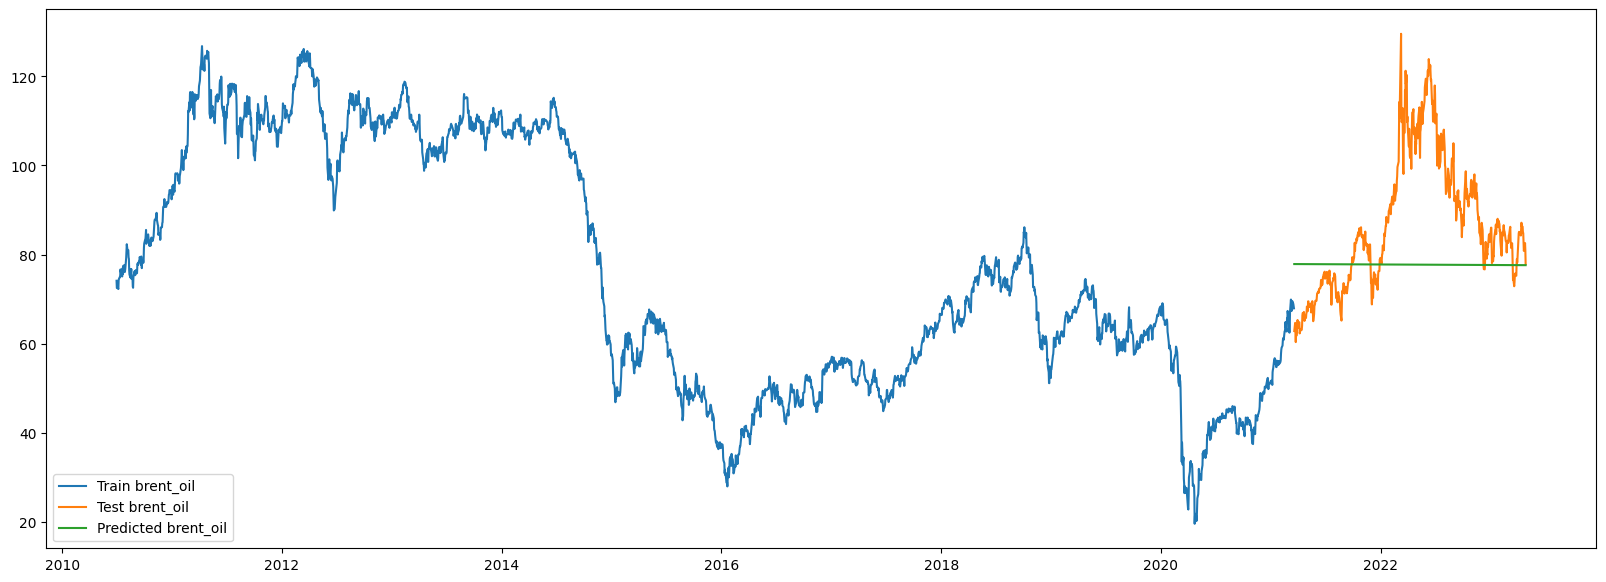

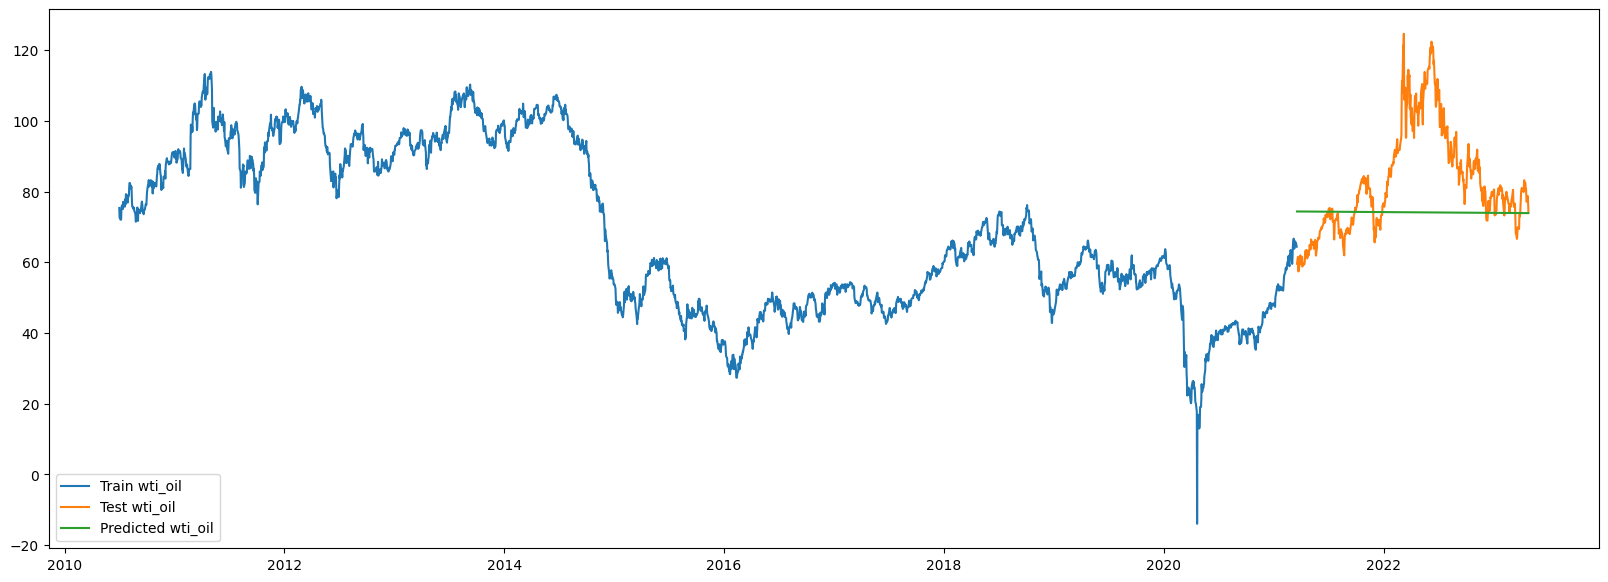

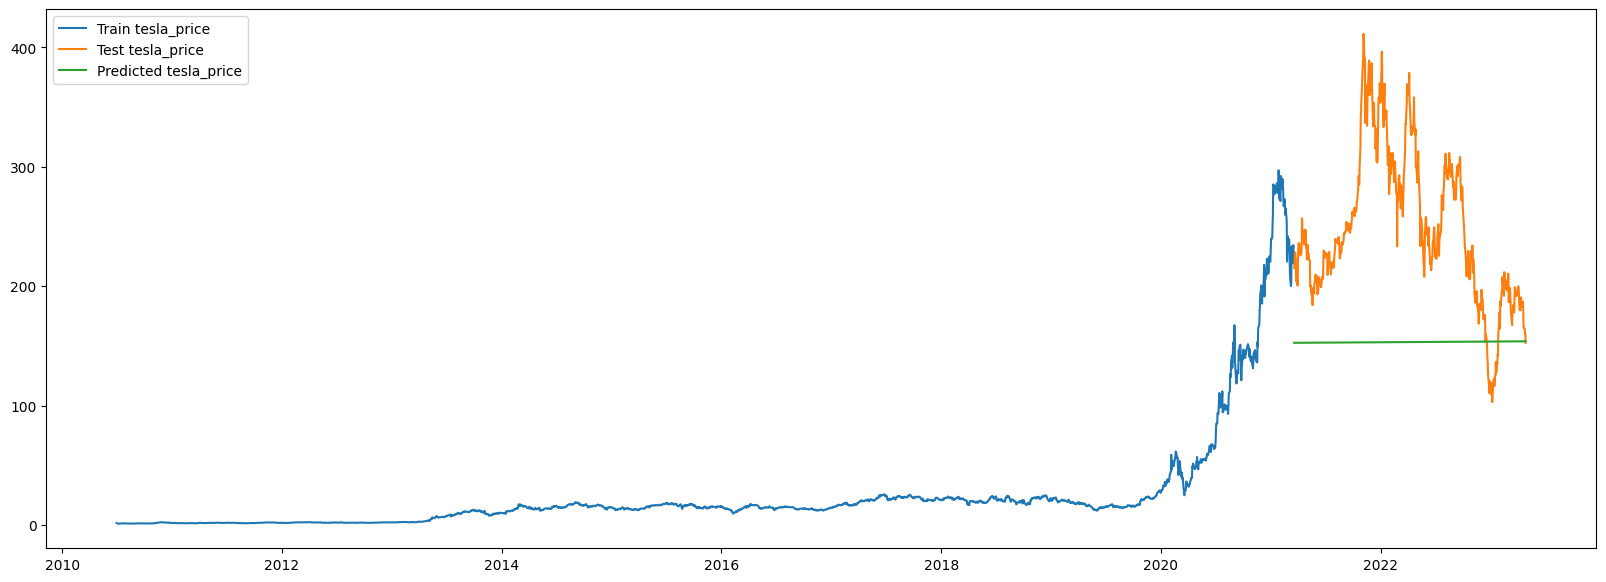

In [232]:
import matplotlib.pyplot as plt
%matplotlib inline

for i in ['effective_rate', 'usd_kwon', 'brent_oil', 'wti_oil', 'tesla_price']:
    
    plt.rcParams["figure.figsize"] = [20,7]
    plt.plot(train[str(i)], label='Train '+str(i))
    plt.plot(test_df[str(i)], label='Test '+str(i))
    plt.plot(inv_forecast_df_truncated[str(i)+'_1st_inv_diff'], label='Predicted '+str(i))
    plt.legend(loc='best')
    plt.show()